In [32]:
%matplotlib inline
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12., 8.)

## Exercise 1

Use the `curve_fit` function to fit a quadratic polynomial function to the data, plot the result and compare the erro with the previous fits.

In [2]:
a = -1
b = 5

def f(x, a, b):
    return np.exp(a * x) + b

x = np.linspace(0, 5, 100)
y = f(x, a, b) + np.random.normal(0, 0.1, 100)

In [25]:
from scipy.optimize import curve_fit

def f_quadratic(x, a, b, c):
    return a*x**2 + b**x + c

quad_params, quad_covariance_matrix = curve_fit(f_quadratic, x, y)
y_fit = f_quadratic(x, *quad_params)
error = ((y - y_fit)**2).sum()

print('parameters: {}'.format(quad_params))
print('error: {}'.format(error))

parameters: [2.32254551e-03 4.26848523e-01 4.93862035e+00]
error: 1.1261221169533036


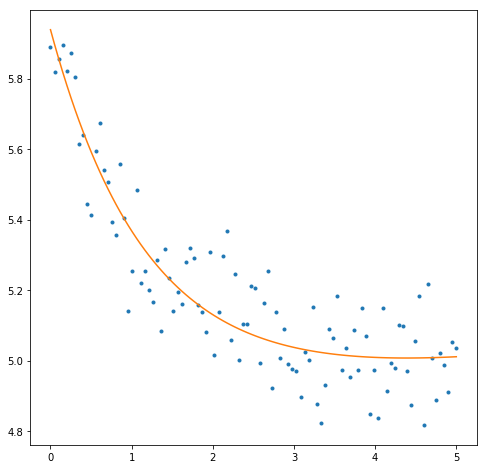

In [26]:
plt.plot(x, y, '.')
plt.plot(x, y_fit)

<a id=exercise_2></a>
### Exercise 2

Do the same to estimate the parameters of a gaussian distribution.

Generate a sample of a normal distribution with $\mu = 10$ and $\sigma = 6$

pdf:

$$
f(x, \mu, \sigma) =  \frac{1}{\sqrt{2 \pi}} \mathrm{e}^{-0.5 \frac{(x - \mu)^2}{\sigma^2}}
$$

Minimize the negative log-likelihood:

$$
-\log(\mathcal{L}) = -\sum_{i = 0}^N \log\bigl( \frac{1}{\sqrt{2 \pi}} \mathrm{e}^{-0.5 \frac{(x_i - \mu)^2}{\sigma^2}}  \bigr)
$$

You can make use of the `norm.rvs` and `norm.pdf` functions to generate the sample and define the function to be minimized.

/home/francesc/virtualenvs/python3_master_IFAE/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


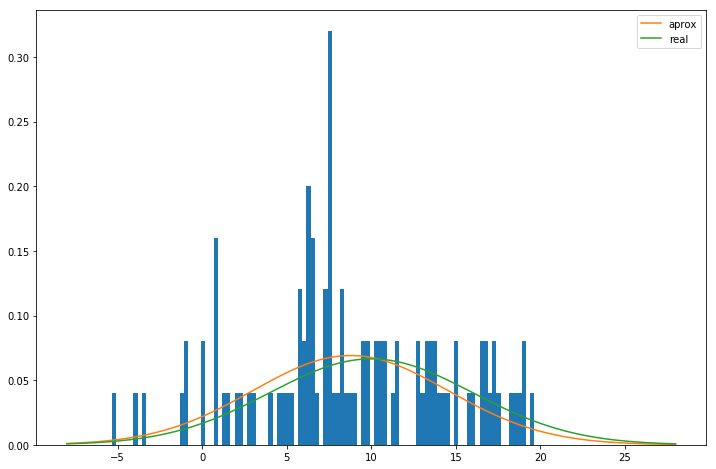

In [33]:
from scipy.optimize import minimize
from scipy.stats import norm

x = norm.rvs(loc=10, scale=6, size=100)

def negative_log_likelihood(params, x):
    mu, sigma = params
    neg_l = -np.sum(np.log(norm.pdf(x, mu, sigma)))
    return neg_l


result = minimize(
    negative_log_likelihood,
    x0=(0., 1.),   # initial guess
    args=(x, ),            # additional arguments for the function to minimize
    bounds=[
        (None, None),      # no bounds for mu
        (1e-32, None)         # sigma > 0
    ],
    method='L-BFGS-B', # method that supports bounds
)

x_plot = np.linspace(-8, 28, 1000)

plt.hist(x, bins=100, normed=True)
plt.plot(x_plot, norm.pdf(x_plot, *result.x), label='aprox')
plt.plot(x_plot, norm.pdf(x_plot, 10., 6.), label='real')
plt.legend();

### Exercise 3

Apply the `trapz` function to calculate:

$$
\int_{-4}^{4} \sqrt[3]{(1 - x^3)} dx
$$

**Hint** use the `np.cbrt` function

In [47]:
from scipy.integrate import trapz

def f(x):
    x0 = np.cbrt(1 - x**3)
    return x0

/home/francesc/virtualenvs/python3_master_IFAE/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  


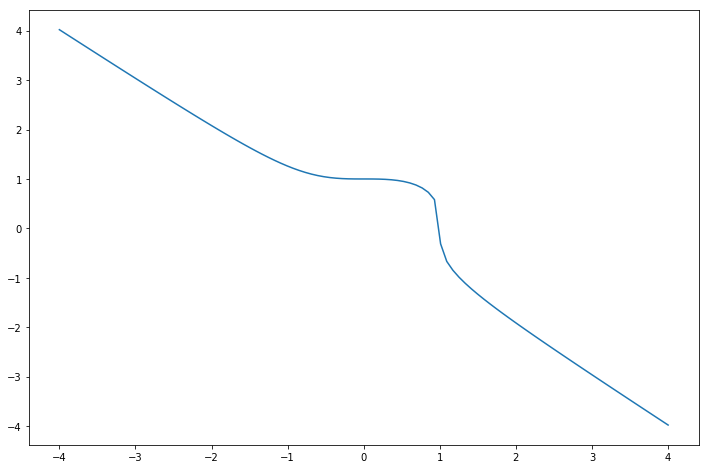

In [52]:
x = np.linspace(-4, 4, 100)
y = f(x)
plt.plot(x, y)

In [53]:
trapz(x, y)

-2.3017199724935655

## Exercise 4

Interpolate the $sinc$ function we have already seen, using:
* two samples of 10 and 100 points
* linear interpolation and cubic splines
* on the [-10, 10] interval

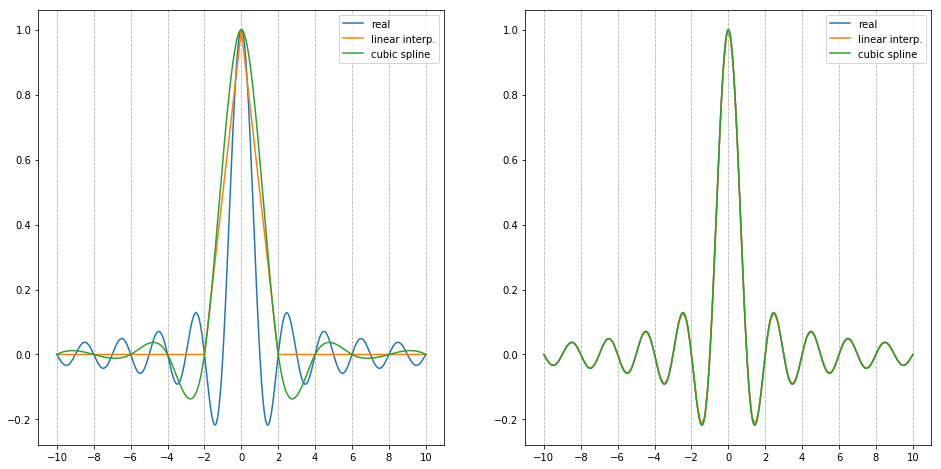

In [85]:
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d

XLIM = (-10, 10)
SAMPLE1 = 10
SAMPLE2 = 100

x = np.linspace(*XLIM, 1000)
y = np.sinc(x)

x1 = np.linspace(*XLIM, SAMPLE1 + 1)
x2 = np.linspace(*XLIM, SAMPLE2 + 2)
xs = [x1, x1]

y1 = np.sinc(x1)
y2 = np.sinc(x2)
ys = [y1, y2]

# linear interpolation
fl = [interp1d(x1, y1),
      interp1d(x2, y2)]

# The cubic spline
fc = [CubicSpline(x1, y1),
      CubicSpline(x2, y2)]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for i, ax in enumerate(axes):
    ax.plot(x, y, label='real')
    ax.plot(x, fl[i](x), label='linear interp.')
    ax.plot(x, fc[i](x), label='cubic spline')
    ax.set_xticks(xs[i])
    ax.grid(axis='x', linestyle='--')
    ax.legend()

## Exercise 5

## Exercise 6

Use a FFT to identify the two offending noise frequencies. Then convert the `lowpass_filter` above into a bandstop filter (hint: it is a trivial modification), and remove the offending noise from the data as much as possible (it won't be perfect). Finally, use `curvefit` to fit a Gaussian to the data, thereby recovering the original signal.

Noise frequencies: [1.2 9. ]
Gaussian paramaters: [3.14771781 0.20905588 2.91577083]


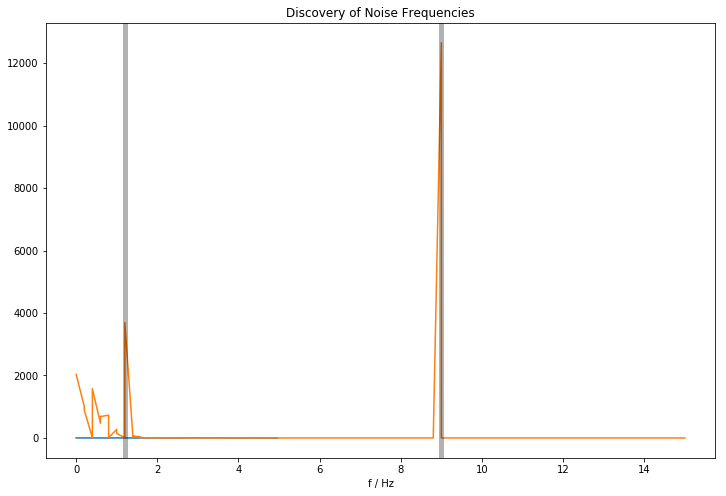

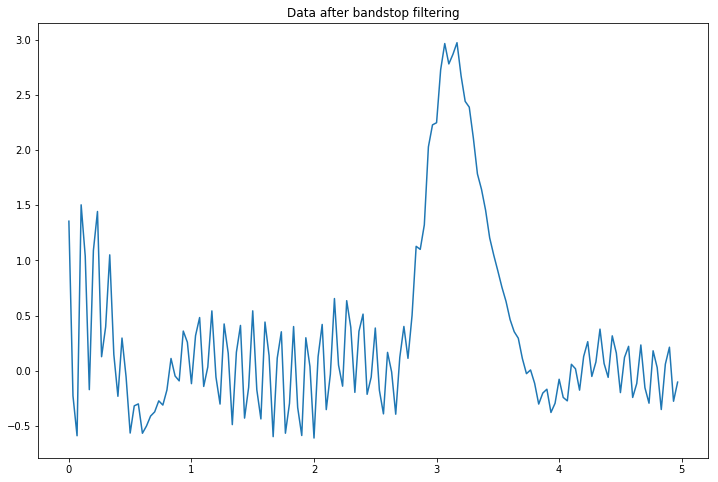

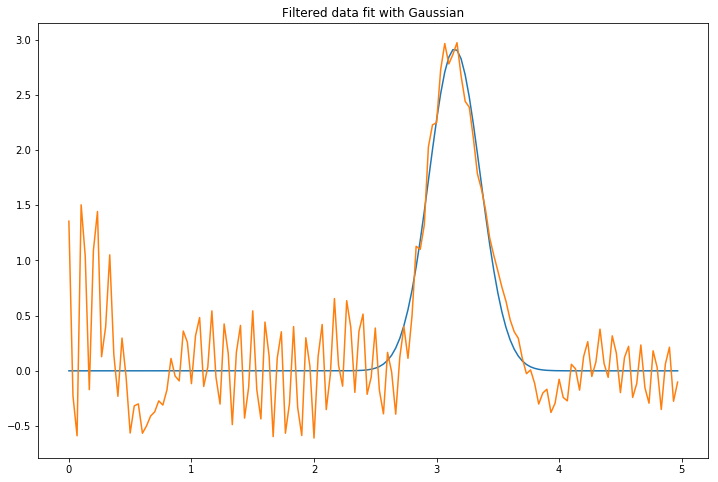

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import butter, lfilter
from scipy import fftpack

def gaussian(x, mu, sigma, A):
    return A*np.exp(-(x - mu)**2/(2*sigma**2))

sample_rate = 30
T = 5
t = np.linspace(0, T, T*sample_rate, endpoint=False)
y = gaussian(t, 3.1, 0.2, 3) + np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t)
plt.plot(t, y)

z = fftpack.rfft(y)
f = fftpack.rfftfreq(len(t), t[1] - t[0])

maxima = f[np.abs(z)**2 > 2100]
print("Noise frequencies:", maxima)

plt.figure(1)
plt.plot(f, np.abs(z)**2)
plt.xlabel('f / Hz')
for freq in maxima:
    plt.axvline(x=freq, color='black', alpha=0.3, lw=5)
plt.title('Discovery of Noise Frequencies')

def bandstop_filter(data, freq_window, fs, order=5):
    nyquist_frequency = fs/2
    freq_window = np.array(freq_window)
    normal_freq = freq_window/nyquist_frequency
    b, a = butter(order, normal_freq, btype='bandstop')
    y = lfilter(b, a, data)
    return y

plt.figure(2)
sample_rate = (len(t) - 1)/(t[-1])
y_filt = bandstop_filter(y, [1.15, 1.25], sample_rate)
y_filt = bandstop_filter(y_filt, [8.9, 9.1], sample_rate)
plt.plot(t, y_filt)
plt.title('Data after bandstop filtering')

params, __ = curve_fit(gaussian, t, y_filt)
print("Gaussian paramaters:", params)

plt.figure(3)
plt.plot(t, gaussian(t, *params))
plt.plot(t, y_filt)
plt.title('Filtered data fit with Gaussian');

## Exercise 7
Orthogonal polynomials can be used to construct a series expansion of an arbitrary function, just like $\sin$ and $\cos$ are used to construct a Fourier series. For example, we can express a function $f(x)$ as a series of Legendre polynomials $P_n(x)$:

$$ f(x) = \sum_{n=0}^{\infty} a_n P_n(x) $$

The Legendre polynomials are orthogonal on the interval $x \in [-1, 1]$, where they obey the following orthogonality relationship:
$$ \int_{-1}^{1} P_n(x) \, P_m(x) \, dx = \frac{2}{2 m + 1} \delta_{mn} $$

With $f(x) = sin(\pi x)$, write a function to calculate the coefficients $a_n$ of the Legendre series. Then plot $f(x)$ and the Legendre series for $x \in [-1, 1]$. Calculate as many coefficients as are needed for the series to essentially the same as $f(x)$ (it will be less than ten).

If you are struggling with the math, look [here](http://mathworld.wolfram.com/Fourier-LegendreSeries.html).

Coefficients: [0.0, 0.954929658551372, 4.213343393869503e-18, -1.1582419121994119, -6.445393259196511e-18, 0.21928954721622917]


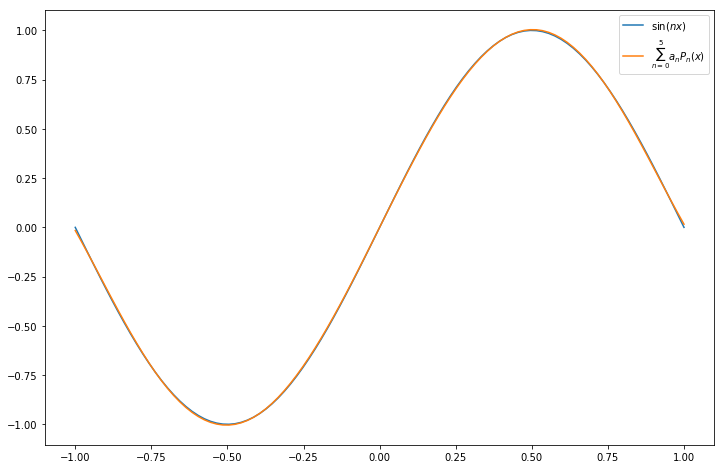

In [86]:
from scipy.special import eval_legendre
from scipy.integrate import quad

def f(x):
    return np.sin(np.pi*x)

def a(n):
    g = lambda x: f(x)*eval_legendre(n, x)
    integral = quad(g, -1, 1)[0]
    return (2*n + 1)/2 * integral

# first few a_n coefficients up to n = 5
print("Coefficients:", [a(n) for n in range(5+1)])

def legendre_series(x, N):
    y = np.zeros(len(x))
    for n in range(N+1):
        y += a(n)*eval_legendre(n, x)
    return y

x = np.linspace(-1, 1, 100)
plt.plot(x, f(x), label=r'$\sin(nx)$')
plt.plot(x, legendre_series(x, 5), label=r'$\sum_{n=0}^{5} a_n P_n(x)$')
plt.legend(loc='best');